In [3]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from pprint import pprint
import numba

In [4]:
def show(a, ievt=0):
    pprint(a[ievt].tolist())

In [213]:
filename = ["root://xrootd-cms.infn.it///store/mc/RunIIAutumn18NanoAOD/GluGluHToBB_M125_13TeV_powheg_pythia8/NANOAODSIM/102X_upgrade2018_realistic_v15-v1/90000/D6407856-BDE7-C341-B778-0406CA4A2136.root.root"]
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()


dataset = "ggHTobb"

TypeError: Invalid file type (<class 'list'>)

In [6]:
ievt = 0

In [7]:
#load_ext snakeviz

In [184]:
#timeit
#selects gen b quarks with at least a muon child
isOutgoing = events.GenPart.status == 1

muonChild = (abs(ak.any(events.GenPart.children.pdgId))==13)
eleChild = abs(ak.any(events.GenPart.children.pdgId))==11
bquarks = events.GenPart[isB & isOutgoing ]


# Select b-quarks at Gen level, coming from H->bb decay
if dataset == 'ggHTobb':
    
    #It is a b quark
    isB = abs(events.GenPart.pdgId) == 5
    
    #has a muon child (will/can be substituted with lepton child if needed)
    hasMuonChildren =  ak.any(abs(events.GenPart.children.pdgId)==13)
    
    #has H mother from hard process
    hasHmother = events.GenPart[events.GenPart.genPartIdxMother].pdgId==25
    hasHardMother = events.GenPart[events.GenPart.genPartIdxMother].hasFlags(['fromHardProcess'])
    
    #apply mask to GenParticles
    bquarks = events.GenPart[isB & hasHmother & hasMuonChildren]
   
    # Sort b-quarks by pt
    bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')
    print(bquarks.pt)
 

[[71.5, 54.4], [40.6, 33.5], [60.2, 46.6], ... 96.8, 84], [67.8, 13.5], [75.8, 54.6]]


In [196]:
#isOutgoing = events.LHEPart.status == 1
#isB = abs(events.LHEPart.pdgId) == 5
#bquarks = events.LHEPart[isB & isOutgoing]

#higgs = events.GenPart[(events.GenPart.pdgId == 25) & events.GenPart.hasFlags(['fromHardProcess'])]
#higgs = higgs[ak.num(higgs.childrenIdxG, axis=2) == 2]
#bquarks = ak.concatenate( (bquarks, ak.flatten(higgs.children, axis=2)), axis=1 )
# Sort b-quarks by pt
#bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')

In [197]:
#bquarks = events.LHEPart[isB & isOutgoing]

In [198]:
#%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4

#ask for exactly one muon in the B jet
mask_mu1 = events.Jet.muonIdx1!= -1

#mask_mu2 = events.Jet.muonIdx2!= -1
#define muon_jet collection
events["muon_Jet"] = events.Jet[ mask_mu1 ] 

gen_mu = events.Muon.genPartIdx[events.muon_Jet.muonIdx1]!=-1

#require for the muon to be a genMatched mu
match_mu1 = abs(events.GenPart.pdgId[events.Muon.genPartIdx[events.muon_Jet.muonIdx1]])==13
match_mu2 = abs(events.GenPart.pdgId[events.Muon.genPartIdx[events.muon_Jet.muonIdx2]])==13

#recompute muon_Jet
events["muon_Jet"] = events.Jet[match_mu1 ] 

#compute dR between gen b quarks and reco-jets
deltaR = ak.flatten(bquarks.metric_table(events.muon_Jet), axis=2)

#print(ak.flatten(deltaR))
# keeping only the pairs with a deltaR min

#build the mask for matching and apply it
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR]

#show(deltaRcut,1)#--> the mask works since we are applying it also to the argcartesian

idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
#get the gen b -recojet matched pairs 
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]

#show(pairs,1)

pairs_sorted = pairs[idx_pairs_sorted]
deltaR_sorted = deltaRcut[idx_pairs_sorted]

#get the orderd indexes for the pairs in each collection 
idx_quark, idx_jets = ak.unzip(pairs_sorted)



[[{eta: -0.165, mass: 0, phi: 0.75, pt: 71.5, ... 6587399, 6587401, 6587400]}]]
[[Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet, ... Jet, Jet, Jet, Jet, Jet, Jet, Jet]]
[3.41, 3.83, 0.165, 2.92, 0.0656, 1.83, ... 0.401, 2.24, 1.69, 2.6, 0.00562, 3.19]


In [199]:
#show(pairs,1)

In [200]:
#show(idx_pairs_sorted,1)

In [201]:
#pairs_sorted[0:100].tolist()

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [(0, 0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [],
 [(0, 1)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [(0, 0)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 0)],
 [],
 [],
 [(0, 0)],
 []]

In [202]:
def get_valid_pairs_masks(idx_bquarks, idx_Jet):
    hasMatch = ak.zeros_like(idx_Jet, dtype=bool)
    Npairmax = ak.max(ak.num(idx_bquarks))
    # Loop over the (parton, jet) pairs
    for idx_pair in range(Npairmax):
        idx_bquark = ak.pad_none(idx_bquarks, Npairmax)[:,idx_pair]
        idx_match_candidates = idx_Jet[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        idx_pair_candidates  = ak.local_index(idx_Jet)[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        #print(idx_bquark[ievt], idx_match_candidates[ievt])
        #print(idx_bquark[ievt], idx_pair_candidates[ievt])
        if idx_pair == 0:
            idx_matchedJet    = ak.unflatten( ak.firsts(idx_match_candidates), 1 )
            idx_matchedParton = ak.unflatten( idx_bquark, 1 )
            idx_matchedPair   = ak.unflatten( ak.firsts(idx_pair_candidates), 1 )
        else:
            # If the partons are matched in all events or the number of jets is smaller than the number of partons, stop iterating
            if ak.all( ( (ak.count(idx_matchedJet, axis=1) == ak.count(bquarks.pt, axis=1)) | (ak.count(events.Jet.pt, axis=1) < ak.count(bquarks.pt, axis=1) ) ) ): break
            idx_matchedJet    = ak.concatenate( (idx_matchedJet, ak.unflatten( ak.firsts(idx_match_candidates), 1 ) ), axis=1 )
            idx_matchedParton = ak.concatenate( (idx_matchedParton, ak.unflatten( idx_bquark, 1 )), axis=1 )
            idx_matchedPair   = ak.concatenate( (idx_matchedPair, ak.unflatten( ak.firsts(idx_pair_candidates), 1 ) ), axis=1 )
        # The mask `hasMatch` masks to False the 
        hasMatch = hasMatch | ak.fill_none(idx_Jet == ak.fill_none(ak.firsts(idx_match_candidates), -99), False) | ak.fill_none(idx_bquarks == idx_bquark, False)
        #print(idx_pair, hasMatch[ievt].tolist(), end='\n\n')

    idx_matchedParton = idx_matchedParton[~ak.is_none(idx_matchedJet, axis=1)]
    idx_matchedJet = idx_matchedJet[~ak.is_none(idx_matchedJet, axis=1)]
    return idx_matchedParton, idx_matchedJet

In [203]:
def get_valid_pairs_nonumba(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for q,j in zip(ev_q, ev_j):
            if q not in q_done and j not in j_done:
                builder.begin_record("pair")
                builder.field("quark").append(q)
                builder.field("jet").append(j)
                builder.end_record()
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [204]:
def get_valid_pairs_index(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done and j not in j_done:
                builder.append(i)
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [205]:
def get_dijet(jets, transverse=False):

    fields = {
        "pt": -1,
        "eta": 1000,
        "phi": 1000,
        "mass": -1,
    }
  
    jets= ak.pad_none(jets, 2)
    
    njets = ak.num(jets[~ak.is_none(jets, axis=1)])

    

    jj = jets[:,0] + jets[:,1]
    jet1 = jets[:,1]
    
    jet2 = jets[:,1]
    deltaR = jet1.delta_r(jet2)
 

    for var in fields.keys():
    
        fields[var] = ak.where(
            (njets==2),
            getattr(jj, var),
            fields[var],
        )
 #   print(fields['mass'])
    if transverse:
        fields["eta"] = ak.zeros_like(fields["pt"])
    dijets = ak.zip(fields, with_name="PtEtaPhiMCandidate")
    dijets = ak.with_field(dijets, deltaR, "dRdiJet", behavior=dijets.behavior)
    return dijets



### Checking the results

In [206]:
idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
pairs_sorted[idx_matched][10].tolist()


[]

27314


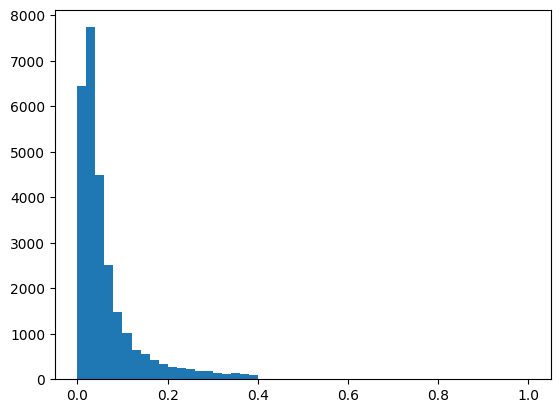

In [207]:
plt.hist(ak.flatten(deltaR_sorted[idx_matched]), bins=50, range=(0, 1))

print(len(ak.flatten(idx_matched)))
# plt.yscale("log")


In [208]:
events.Jet[idx_jets[idx_matched]][10]

<JetArray [] type='0 * jet'>

In [209]:
#idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
#idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
print(len(idx_matched))
print()
# The invalid jet matches result in a None value. Only non-None values are selected.
matched_quarks = bquarks[idx_quark[idx_matched]]
matched_jets = events.Jet[idx_jets[idx_matched]]
deltaR_matched = deltaRcut[idx_matched]
print(len(matched_jets))
print(len(matched_quarks))

176000

176000
176000


[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]


(array([1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0.,
        0., 2., 5., 4., 5., 0., 1., 4., 2., 7., 2., 2., 4., 5., 1., 3., 1.,
        3., 2., 4., 3., 1., 0., 1., 3., 0., 2., 0., 2., 1., 1., 1., 2.]),
 array([ 63.09249878,  64.45469391,  65.81688904,  67.17908417,
         68.5412793 ,  69.90347443,  71.26566956,  72.62786469,
         73.99005981,  75.35225494,  76.71445007,  78.0766452 ,
         79.43884033,  80.80103546,  82.16323059,  83.52542572,
         84.88762085,  86.24981598,  87.61201111,  88.97420624,
         90.33640137,  91.6985965 ,  93.06079163,  94.42298676,
         95.78518188,  97.14737701,  98.50957214,  99.87176727,
        101.2339624 , 102.59615753, 103.95835266, 105.32054779,
        106.68274292, 108.04493805, 109.40713318, 110.76932831,
        112.13152344, 113.49371857, 114.8559137 , 116.21810883,
        117.58030396, 118.94249908, 120.30469421, 121.66688934,
        123.02908447, 124.3912796 , 125.75347473, 127.11566986,
      

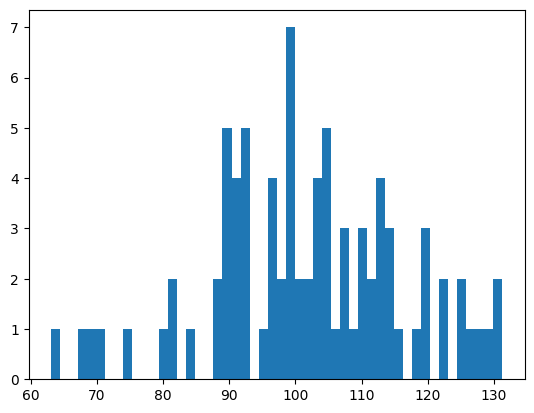

In [210]:
events["PartonMatched"] = ak.with_field(matched_quarks, deltaR_matched, "dRMatchedJet", behavior=matched_quarks.behavior)
events["JetMatched"] = ak.with_field(matched_jets, deltaR_matched, "dRMatchedJet", behavior=matched_jets.behavior)


jj = get_dijet(events.JetMatched)

#print(events.JetMatched.type)

print(events.JetMatched.partonFlavour)

plt.hist(jj.mass[jj.mass!=-1], bins=50)



In [ ]:
ak.num(events.PartonMatched, axis=1)

### Check profiling

In [ ]:
%%snakeviz 
results1 = get_valid_pairs_masks(idx_quark, idx_jets)

In [ ]:
%%snakeviz 
results3 = get_valid_pairs_numba(idx_quark, idx_jets, ak.ArrayBuilder())

### Check the performance of first part of the algo

In [ ]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2) 

In [ ]:
%%timeit
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian

In [ ]:
%%timeit  pass
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)


In [ ]:
%%timeit pass
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]

In [ ]:
%%timeit pass
pairs_sorted = pairs[idx_pairs_sorted]


In [ ]:
%%timeit pass
idx_quark, idx_jets = ak.unzip(pairs_sorted)

In [ ]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
idx_quark, idx_jets = ak.unzip(pairs_sorted)
       

In [ ]:
idx_quark